In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import numpy as np
import pandas as pd
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image
from tqdm import tqdm, trange
import cv2
import numba as nb
from ast import literal_eval

plt.style.use('seaborn-whitegrid')



# Functions to map between cartesian coordinates and array indexes
@nb.njit
def cartesian_to_array(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j

@nb.njit
def array_to_cartesian(i, j, shape):
    m, n = shape[:2]
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    y = (n - 1) // 2 - i
    x = j - (n - 1) // 2
    return x, y


point = (1, 8)
shape = (9, 9, 3)
assert cartesian_to_array(*array_to_cartesian(*point, shape), shape) == point


# Functions to map an image between array and record formats
def image_to_dict(image):
    image = np.atleast_3d(image)
    kv_image = {}
    for i, j in product(range(len(image)), repeat=2):
        kv_image[array_to_cartesian(i, j, image.shape)] = tuple(image[i, j])
    return kv_image


def image_to_df(image):
    return pd.DataFrame(
        [(x, y, r, g, b) for (x, y), (r, g, b) in image_to_dict(image).items()],
        columns=['x', 'y', 'r', 'g', 'b']
    )


def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    return df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)


def imread(path):
    if isinstance(path, Path):
        path = path.as_posix()
    return cv2.imread(path)[:, :, ::-1] / 255


@nb.njit
def get_position(config):
    return config.sum(0)

@nb.njit
def rotate_link(vector, direction):
    x, y = vector
    if direction == 1:  # counter-clockwise
        if y >= x and y > -x:
            x -= 1
        elif y > x and y <= -x:
            y -= 1
        elif y <= x and y < -x:
            x += 1
        else:
            y += 1
    elif direction == -1:  # clockwise
        if y > x and y >= -x:
            x += 1
        elif y >= x and y < -x:
            y += 1
        elif y < x and y <= -x:
            x -= 1
        else:
            y -= 1
    return (x, y)

@nb.njit
def rotate(config, i, direction):
    config = config.copy()
    config[i] = rotate_link(config[i], direction)
    return config


# compress a path between two points
@nb.njit
def compress_path(path):
    n_joints = path.shape[1]
    r = np.zeros((n_joints, path.shape[0], 2), dtype=path.dtype)
    l = np.zeros(n_joints, dtype='int')
    for j in range(len(path)):
        for i in range(n_joints):
            if l[i] == 0 or (r[i][l[i] - 1] != path[j, i]).any():
                r[i, l[i]] = path[j, i]
                l[i] += 1
    r = r[:, :l.max()]

    for i in range(n_joints):
        for j in range(l[i], r.shape[1]):
            r[i, j] = r[i, j - 1]
    r = r.transpose(1, 0, 2)

    return r


@nb.njit
def get_direction(u, v):
    """Returns the sign of the angle from u to v."""
    # direction = np.sign(np.cross(u, v))
    direction = np.sign(u[0] * v[1] - u[1] * v[0])
    if direction == 0 and (u * v).sum() < 0:
        direction = 1
    return direction


@nb.njit
def get_radius(config):
    r = 0
    for link in config:
        r += np.abs(link).max()
    return r

@nb.njit
def get_radii(config):
    radii = np.cumsum(np.maximum(np.abs(config[:, 0]), np.abs(config[:, 1]))[::-1])[::-1]
    return np.append(radii, np.zeros(1, dtype='int'))


@nb.njit
def get_path_to_point(config, point):
    """Find a path of configurations to `point` starting at `config`."""
    config_start = config.copy()
    radii = get_radii(config)

    # Rotate each link, starting with the largest, until the point can
    # be reached by the remaining links. The last link must reach the
    # point itself.
    for i in range(len(config)):
        link = config[i]
        base = get_position(config[:i])
        relbase = point - base
        position = get_position(config[:i+1])
        relpos = point - position
        radius = radii[i + 1]
        # Special case when next-to-last link lands on point. 
        if radius == 1 and (relpos == 0).all():
            config = rotate(config, i, 1)
            if (get_position(config) == point).all():
                break
            else:
                continue
        while np.max(np.abs(relpos)) > radius:
            direction = get_direction(link, relbase)
            config = rotate(config, i, direction)
            link = config[i]
            base = get_position(config[:i])
            relbase = point - base
            position = get_position(config[:i+1])
            relpos = point - position
            radius = get_radius(config[i + 1:])

    assert (get_position(config) == point).all()
    path = get_path_to_configuration(config_start, config)

    return path


@nb.njit
def get_path_to_configuration(from_config, to_config):
    path = np.expand_dims(from_config, 0).copy()
    config = from_config.copy()
    while (config != to_config).any():
        for i in range(len(config)):
            config = rotate(config, i, get_direction(config[i], to_config[i]))
        path = np.append(path, np.expand_dims(config, 0), 0)
    assert (path[-1] == to_config).all()
    return path


# Functions to compute the cost function

# Cost of reconfiguring the robotic arm: the square root of the number of links rotated
@nb.njit
def reconfiguration_cost(from_config, to_config):
    diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
    assert diffs.max() <= 1
    return np.sqrt(diffs.sum())


# Cost of moving from one color to another: the sum of the absolute change in color components
@nb.njit
def color_cost(from_position, to_position, image, color_scale=3.0):
    return np.abs(image[to_position] - image[from_position]).sum() * color_scale


# Total cost of one step: the reconfiguration cost plus the color cost
@nb.njit
def step_cost(from_config, to_config, image):
    pos_from = get_position(from_config)
    pos_to = get_position(to_config)
    from_position = cartesian_to_array(pos_from[0], pos_from[1], image.shape)
    to_position = cartesian_to_array(pos_to[0], pos_to[1], image.shape)
    return (
        reconfiguration_cost(from_config, to_config) +
        color_cost(from_position, to_position, image)
    )

# Compute total cost of path over image
@nb.njit
def total_cost(path, image):
    cost = 0
    for i in range(1, len(path)):
        cost += step_cost(path[i - 1], path[i], image)
    return cost


def get_origin(size):
    assert size % 2 == 1
    radius = size // 2
    p = [1]
    for power in range(0, 8):
        p.append(2**power)
        if sum(p) == radius:
            break
    else:
        assert False
    p = p[::-1]
    config = np.array([(p[0], 0)] + [(-pp, 0) for pp in p[1:]])
    return config


def points_to_path(points, size=257):
    origin = get_origin(size)

    visited = set()
    path = [origin]
    for p in points:
        config = path[-1]
        if tuple(p) not in visited:
            candy_cane_road = get_path_to_point(config, p)[1:]
            if len(candy_cane_road) > 0:
                visited |= set([tuple(get_position(r)) for r in candy_cane_road])
            path.extend(candy_cane_road)
    # Back to origin
    candy_cane_road = get_path_to_configuration(path[-1], origin)[1:]
    visited |= set([tuple(get_position(r)) for r in candy_cane_road])
    path.extend(candy_cane_road)
    
    assert len(visited) == size**2, f'Visited {len(visited)} points out of {size**2}'
    
    return np.array(path)


@nb.njit
def dir2idx(dx, dy):
    assert dx >= -1 and dx <= 1 and dy >= -1 and dy <= 1
    assert not (dx == 0 and dy == 0)
    idx = (dx + 1) * 3 + dy + 1
    if idx > 4:
        idx = idx - 1
    return idx

@nb.njit
def idx2dir(idx):
    assert idx >= 0 and idx < 8
    if idx >= 4:
        idx = idx + 1
    dx = idx // 3 - 1
    dy = idx % 3 - 1
    return dx, dy

@nb.njit
def idx2newij(i, j, idx):
    dx, dy = idx2dir(idx)
    new_i = i - dy
    new_j = j + dx
    return new_i, new_j

# test
for i in range(8):
    assert dir2idx(*idx2dir(i)) == i


def plot_traj(points, image, ax=None, **figure_args):
    
    if ax is None:
        _, ax = plt.subplots(**figure_args)
        
    origin = np.array([0, 0])
    lines = []
    if not (origin == points[0]).all():
        lines.append([origin, points[0]])
    for i in range(1, len(points)):
        lines.append([points[i - 1], points[i]])
    if not (origin == points[1]).all():
        lines.append([points[-1], origin])

    colors = []
    for l in lines:
        #print(l)
        dist = np.abs(l[0] - l[1]).max()
        if dist <= 2:
            colors.append('b')
        else:
            colors.append('r')

    lc = mc.LineCollection(lines, colors=colors)

    #fig = plt.figure(figsize=(20,20))
    #ax = fig.add_subplot(111)
    ax.add_collection(lc)

    radius = image.shape[0] // 2
    ax.matshow(image * 0.8 + 0.2, extent=(-radius-0.5, radius+0.5, -radius-0.5, radius+0.5))
    ax.grid(None)

    ax.autoscale()
    #fig.show()
    return ax

def get_position_not_numba(config):
    return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))

def cartesian_to_array_not_numba(x, y, shape):
    m, n = shape[:2]
    i = (n - 1) // 2 - y
    j = (n - 1) // 2 + x
    if i < 0 or i >= m or j < 0 or j >= n:
        raise ValueError("Coordinates not within given dimensions.")
    return i, j



/tmp/ipykernel_6854/3676758674.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


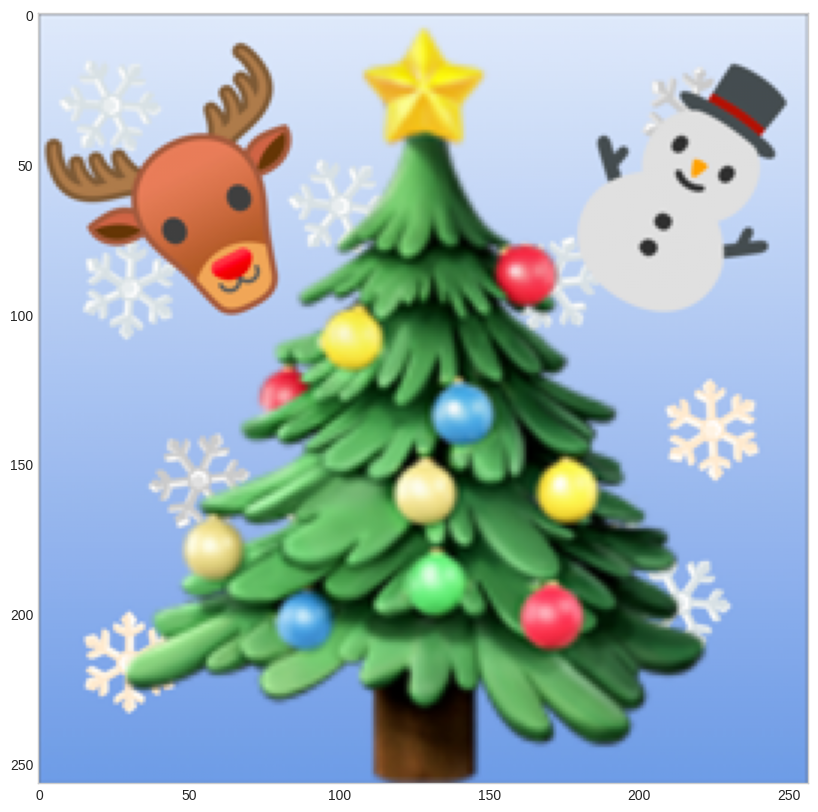

In [2]:
df_img = pd.read_csv('image.csv')
image = df_to_image(df_img)
assert image_to_df(image).equals(df_img) 
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.grid(None);

In [3]:
def get_baseline(image):
    # Generate points
    points_baseline = []
    flag = True
    for split in range(2):
        for i in reversed(range(257)) if split%2==0 else range(257):
            if not flag:
                for j in range(128*split, 128+129*split):
                    points_baseline.append((j-128,i-128))
            else:
                for j in reversed(range(128*split, 128+129*split)):
                    points_baseline.append((j-128,i-128))
            flag = not flag
        flag = False
    points_baseline = np.array(points_baseline)

    # Make path
    path_baseline = points_to_path(points_baseline)

    # Compute cost
    score_baseline = total_cost(path_baseline, image)

    return points_baseline, path_baseline, score_baseline

In [4]:
points_baseline, path_baseline, score_baseline = get_baseline(image)

print("Num points:", len(points_baseline))
print("Num configurations:", len(path_baseline))
print("Score:", score_baseline)

Num points: 66049
Num configurations: 66947
Score: 81875.21630640663


In [4]:
def remove_zeros(l):
    for ele in reversed(l):
        if ele==0 or ele =='':
            del l[-1]
        else:
            break

In [5]:
old_runs = pd.read_csv('runs_1-25.csv')

In [6]:
old_runs.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Run15', 'Run11', 'Run14', 'Run5', 'Run8',
       'Run4', 'Run9', 'Run12', 'Run7', 'Run10', 'Run6', 'Run13', 'Run3',
       'Run16', 'Run1', 'Run2', 'Run17', 'Run18', 'Run19', 'Run20', 'Run21',
       'Run22', 'Run23', 'Run24', 'Run25'],
      dtype='object')

In [7]:
old_runs.drop(['Unnamed: 0.1', 'Unnamed: 0'],axis=1,inplace = True)

In [8]:
points_runs = pd.DataFrame()

In [9]:
old_runs.fillna(0,inplace = True)

In [10]:
old_runs=old_runs.applymap(lambda x: literal_eval(x) if x!=0 else 0)

In [11]:
old_runs_pts= old_runs.applymap(lambda x: cartesian_to_array_not_numba(*get_position_not_numba(x),image.shape) if x!=0 else 0)

In [12]:
path_pts = pd.DataFrame()


In [13]:
for key,value in old_runs_pts.items():
    pts_runs = []
    pmap = np.zeros((image.shape[:2]),dtype='int')
    for x in value:
        
        if pmap[x[0],x[1]]==0:
            pmap[x[0],x[1]]=1
            pts_runs.append(x)
        if pmap[pmap==1].shape[0] ==pmap.shape[0]*pmap.shape[1]:
            pts_runs.append((128,128))
            pts_runs = pd.Series(pts_runs,name=key)
            path_pts=pd.concat([path_pts,pts_runs],axis=1)
            break
        

In [72]:
path_pts.tail()

,Run15,Run11,Run14,Run5,Run8,Run4,Run9,Run12,Run7,Run10,...,Run2,Run17,Run18,Run19,Run20,Run21,Run22,Run23,Run24,Run25
66045,"(48, 21)","(255, 87)","(249, 79)","(35, 106)","(255, 19)","(42, 249)","(168, 243)","(50, 254)","(65, 94)","(1, 207)",...,"(246, 100)","(6, 66)","(0, 0)","(58, 111)","(165, 221)","(0, 0)","(150, 2)","(162, 109)","(47, 138)","(190, 16)"
66046,"(50, 17)","(255, 86)","(249, 80)","(44, 107)","(255, 20)","(145, 78)","(170, 225)","(51, 254)","(65, 95)","(1, 206)",...,"(210, 96)","(6, 65)","(5, 19)","(30, 77)","(214, 185)","(188, 65)","(166, 55)","(168, 112)","(15, 127)","(190, 17)"
66047,"(75, 130)","(232, 76)","(248, 82)","(49, 115)","(255, 26)","(179, 62)","(166, 208)","(52, 254)","(62, 83)","(47, 62)",...,"(160, 127)","(30, 55)","(5, 20)","(21, 85)","(215, 185)","(188, 66)","(165, 55)","(174, 158)","(21, 251)","(172, 16)"
66048,"(76, 130)","(0, 256)","(254, 80)","(5, 104)","(254, 26)","(179, 61)","(172, 178)","(0, 256)","(59, 102)","(48, 62)",...,"(158, 126)","(0, 0)","(8, 21)","(0, 0)","(153, 108)","(188, 67)","(175, 214)","(174, 159)","(22, 252)","(171, 16)"
66049,"(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)",...,"(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)","(128, 128)"


In [16]:
pathplot = np.array(path_pts.loc[:,'Run19'].values.flatten().tolist())

In [19]:
pathplot=np.apply_along_axis(lambda x:array_to_cartesian(*x,image.shape),1,pathplot)

In [ ]:
fig,axs = plt.subplots(path_pts.shape[1],figsize=(400,400))
for i in range(path_pts.shape[1]):
    pathplot = np.array(path_pts.iloc[:,i].values.flatten().tolist())
    pathplot=np.apply_along_axis(lambda x:array_to_cartesian(*x,image.shape),1,pathplot)
    
    axs[i] = plot_traj(pathplot, image,ax=axs[i])
    axs[i].set_title(path_pts.iloc[:,i].name)

In [47]:
config=old_runs['Run19'][old_runs['Run19']!=0]
    

In [48]:
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


submission = pd.Series(
    [config_to_string(x) for x in config],
    name="configuration",
)

submission.head()

0        64 0;-32 0;-16 0;-8 0;-4 0;-2 0;-1 0;-1 0
1       64 0;-32 0;-16 0;-8 -1;-4 0;-2 0;-1 0;-1 0
2      64 0;-32 -1;-16 0;-8 -1;-4 0;-2 0;-1 0;-1 0
3     64 0;-32 -1;-16 -1;-8 -1;-4 0;-2 0;-1 0;-1 0
4    64 0;-32 -1;-16 -1;-8 -1;-4 0;-2 -1;-1 0;-1 0
Name: configuration, dtype: object

In [50]:
for key,value in old_runs.items():
    config = old_runs[key][old_runs[key]!=0]
    submission = pd.Series(
    [config_to_string(x) for x in config],
    name="configuration",
    )
    submission.to_csv(str(key)+'.csv',index=False)

<AxesSubplot: >

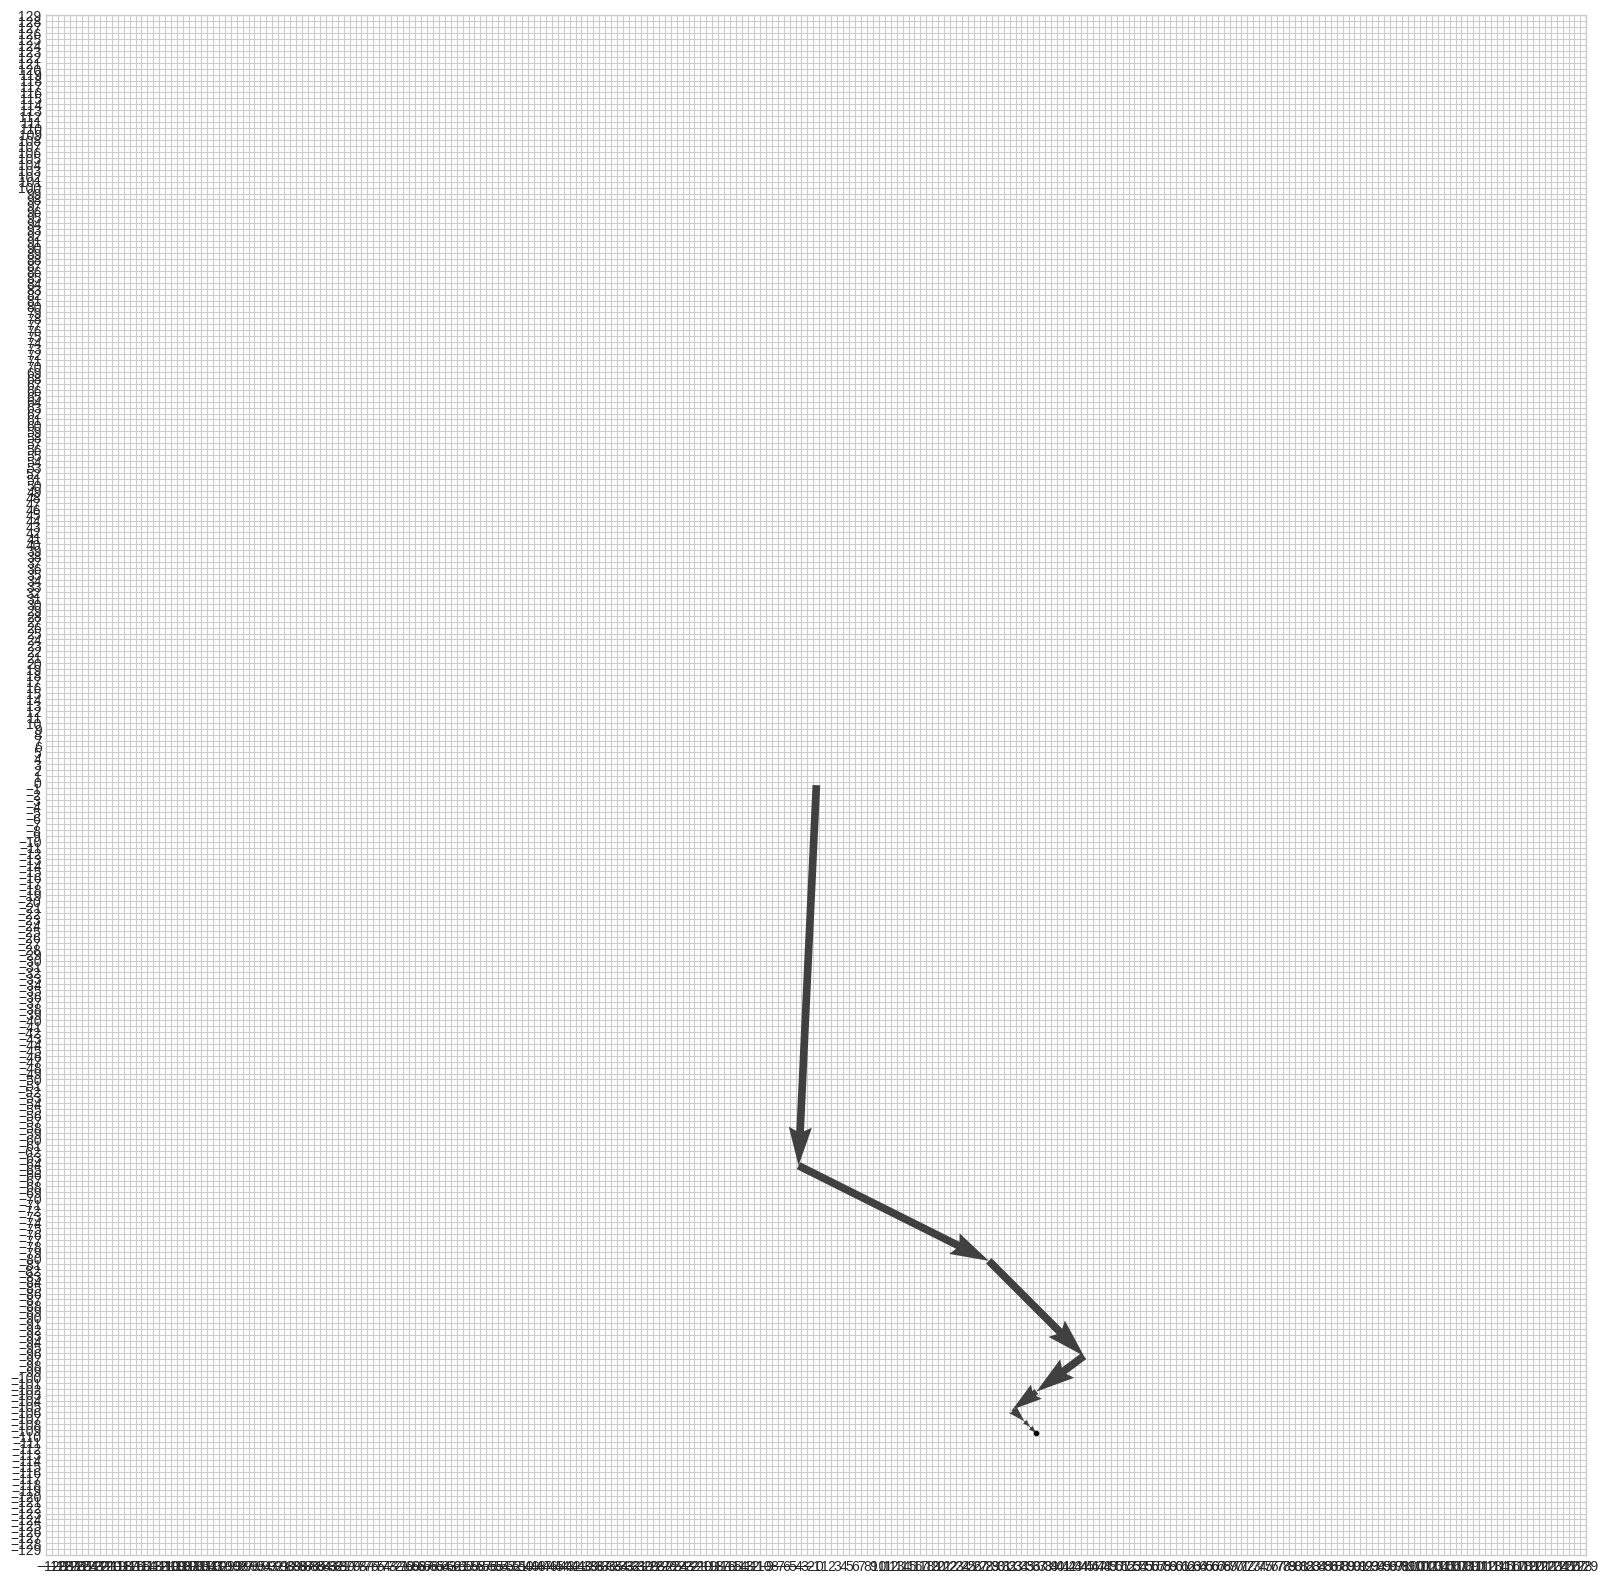

In [261]:
plot_configuration(config[-1],figsize=(20,20))

In [ ]:
# add to dictionary of choices, options from pixels in the array wiehgted by color cost when number of options are 
#low, choices in costs are picked by same distribution, lower cost more likely
#pixels added to options are picked wieighted by similarity in color, so that it is more likely to be taken into dictionary when colour similar to
#current pixel


In [164]:
neigh = get_neighbors(config[-1])
point = (0, 0)
cs = neigh
k = 50
colors = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

fig, ax = plt.subplots(figsize=(100, 100))
for c in cs:
    X, Y = (np.vstack([[(0, 0)], np.asarray(c).cumsum(axis=0)])[:-1].T - 0.5)
    U, V = np.asarray(c).T
    ax.quiver(
        X, Y, U, V,
        angles='xy', scale_units='xy', scale=1,
        color=next(colors),
        width=0.0025,
        zorder=10,
        alpha=0.25,
    )
    point = get_position(c)
    ax.plot(point[0]-0.5, point[1]-0.5, '.', color='k', zorder=11)
point = get_position(config[-1])
ax.plot(point[0]-0.5, point[1]-0.5, 'o', color='C3', zorder=11)
ax.set_xlim(-130, 130)
ax.set_ylim(-130, 130)
ax.set_aspect('equal')
ax.set_xticks(np.arange(-130, 130))
ax.set_yticks(np.arange(-130, 130))
ax.grid(True, color='0.5')
ax.set_title(f"Neighbors of {config[-1]}", fontsize=20);